<a href="https://colab.research.google.com/github/UserZetsu/dl-for-bioscience/blob/main/Homework_ML_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Homework: Implementing simple learning algorithms


> **Due Date: February 5th, 2025 by 1 pm**
>
> Please turn in this completed notebook as an attachment or as a shared link to clay.smyth@ucsf.edu

**Collaboration policy and more**

You're welcome (and highly encouraged) to work with and discuss this homework assignment with others in the class, and feel free to use any resources (textbooks, online notebooks, etc). The only requirement is that the final notebook that you turn in must be your own written work (no copy and pasting, please).

**Overview**



## Before you get started

**1) How to run this notebook**

This Jupyter Notebook can be used in two ways:
* *Option 1: Download the notebook*

  We've included all the imports necessary for this homework. Please make sure you're running Python 3 with PyTorch (and Torchvision) installed and ready to go, along with NumPy and Matplotlib. Although you might find that these models train a bit faster on GPU, this homework assignment should be doable on most modern laptops. If you're having trouble please let us know ASAP.

* *Option 2: Run it online on Google Colaboratory*

  - Colab gives access to a GPU, so it could be useful in case you don't have CUDA installed on your computer (**Note: you can use this as an opportunity to get started on GPU training, but we recommend you develop your model and make sure everything works on CPU first**)
  - Make a copy of this notebook in your Google Drive folder: "File" -> "Save a copy in Drive..."
  - By default, Colab does not make GPUs available, but you can easily access them by selecting GPU in "Runtime" -> "Change runtime type..."
  - Remember that Colab runs in a temporary virtual machine, so all the data created while running the notebook will be lost at the end of the session, or when the runtime disconnects due to inactivity. To preserve data between sessions, there are a couple of options:
    * you can link Colab to your personal Google Drive by mounting it on your runtime, see first cell below.
    * you can download/upload files from the Files tab on the right sidebar.

**3) How to complete this assignment**

  - Fill out the relevant code blocks as indicated
  - Answer questions by writing them directly in the text block. Please keep your written answers concise, most are meant to be answered in a sentence or two.
  - Make figures showing your results and add comments with your observations.
  - Some code is provided for you. Feel free to amend provided code as necessary to complete the assignment. Your implementation for specific portions may require changes to the provided code, which is OK.

***Let's start!***

---

The following command can be used to mount your personal Google Drive folder on the temporary virtual machine, so you can recover data between sessions (follow the instructions, you'll need an authorization code). Additional info [here](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA).


In [249]:
# # Skip this cell if running locally
#from google.colab import drive
#drive.mount('/content/gdrive')

In [250]:
# Import all the necessary libraries
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

# %matplotlib inline

# from IPython.display import Image, display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, TensorDataset, DataLoader

> **Question 0) Why is it important to set the seed for the random number generator?**

Setting a seed ensures reproducibility in your code. If you do not set a seed, you will get different results everytime you run your model. Therefore, when you change hyperparameters or split your data, it will change your output everytime you run your model.




In [251]:
random_seed = 42 # Feel free to pick your favorite number
np.random.seed(random_seed)

### 1. **Simple Regression Task Setup**

We will begin this homework by using gradient descent to accomplish a single-variate regression task.

Regression is a statistical technique for estimating one (dependent) variable from one, or more, other (independent) variables. Here, we will use basic machine learning methodologies to estimate an affine relationship between two variables.

Recall the equation of a line:





$$
y = mx + b
$$



We would like to reformulate this equation into linear alegebra notation, which can be accomplished with the following:

$$
y = \begin{bmatrix}
m & b
\end{bmatrix}
\begin{bmatrix}
x \\
1
\end{bmatrix}
$$



> **Question 1a) What variables in the above equation are the weights we would like to learn?**

We want to know how weights and bias and how they change to map our inputs to the corresponding outputs.


> **Question 1b) Draw the regression task in the form of a neural network.**

Because our regression task is a matrix multiplication followed by an activation function (the identity function), it can be formulated as a very simple artificial neural network with no hidden layers. Attempt to draw the network diagram of our regression task. Feel free to embed an image.

![alt text](images/linear_regression.jpeg "Linear Regression")


Let's begin.

First, let's create a random line that we would like to estimate.

Line parameters: m=7, b=4



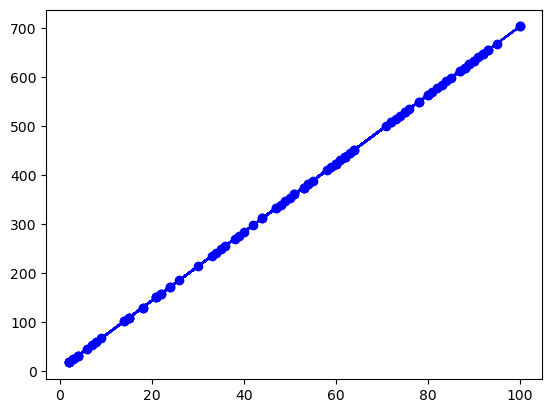

In [252]:
# Creating random slope and intercept to act as our line parameters
m, b = np.random.randint(1, 11), np.random.randint(1, 11)

# Generate a set of 100 (X,Y) coordinates that share the relationship y=mx+b
x = np.random.randint(1,101, size=100)
y = m * x + b
print(f"Line parameters: m={m}, b={b}")
print("")

# Plot the (X,Y) points as a line plot using matplotlib
plt.plot(x, y, label='Line Plot', color='blue', marker='o')

Data is always messy. Let's add some noise to our Y vector to resemble a dataset which we "measured" from the real world, and visualize the new results.

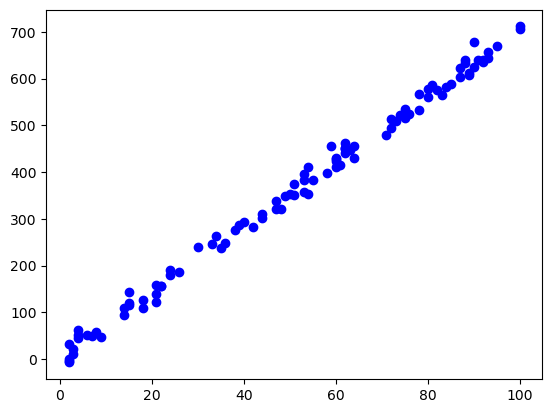

In [253]:
# Add noise to our y-vector
mu, sigma = 0, 15
noise_vector = np.random.normal(mu, sigma, 100)
y_measured = y + noise_vector

# Plot the (X,Y) points as a scatter plot using matplotlib
plt.scatter(x, y_measured, label='Line Plot', color='blue', marker='o')

Now, we would like to estimate the line parameters which best fit our noisy, observed data. We will accomplish this by starting with random weights and updating those weights using gradient descent. We also need to define how "bad" our model is with a loss function.



In [254]:
# Initialize random model weights
def initialize_model(num_weights=2):
  weights = []
  for i in range(num_weights):
    weights.append(np.random.randint(1, 11)) # Only select integers between 1-10.
  return np.array(weights)

In [255]:
weights = initialize_model() # Includes bias term
print(f"Random Weights: m={weights[0]}, b={weights[1]}")

Random Weights: m=9, b=9


In [256]:
# Define your prediction function. This function should return a vector of size x, predicting the y-values.
def predict(weights, x):
  # Hint, it should be the equation of the line from above. Remember to include the bias term for the data points.
  # For an added challenge: Try to use matrix multiplication, and avoid for loops.
  
  y = np.dot(weights[0], x) + weights[1]

  #y = weights[0] * x + weights[1]
  return y

Let's visualize our untrained model's predictions alongside our target data (y_measured).

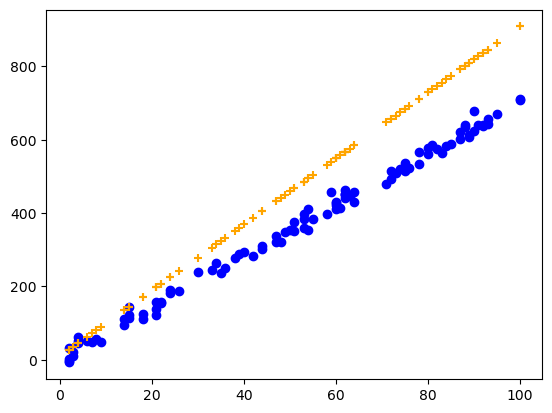

In [257]:
plt.scatter(x, y_measured, label='Line Plot', color='blue', marker='o')
plt.scatter(x, predict(weights, x), color='orange', marker='+')

Next, we need to define a loss function to quantify how "bad" our current model is at predicting our desired data points.


> **Question 1c) What would be a reasonable loss function for our model and observations?**

MSE

In [258]:
# Define loss function
def loss(predictions, targets):
  # Write loss function
  # Student's should likely implement mean-squared error loss
  y = np.mean((predictions - targets)**2)
  return y

Let's see the loss of your untrained model.


In [259]:
predictions = predict(weights, x)
print(loss(predictions, y_measured))

15245.957090865357


Not great! We'll do better after training.

### 2. **Training our Regression**

Now that we have set-up our problem statement, collected data, and defined our model and loss function, we would like to train our model to minimize the loss function. We will accomplish this using gradient descent.

Recall that the gradient is the derivative of the loss function with respect to each weight (or parameter) in our model. The gradient takes the form of a vector.

> **Question 2a) In a few sentences, describe gradient descent?**

Gradient Descent is an algorithm that finds the minima (could be a local or global) of a differentiable function. It will iteratively update the weights and bias so that our model converges to a function that maps our inputs to the outputs

> **Question 2b) What are the partial derivatives of your loss function with respect to each model parameter?**

![alt text](images/lr_gd.jpeg)

In [260]:
# Implement the gradient function for our regression task.
# It should return a vector the same size as the model 'weights' variable.
def gradient_func(x, y, predictions):
  # Your code here
  
  # The error term represents yi - (mx+b) in the drawing above
  error = y - predictions
  
  # Gradient of slope, we compute the dot product of X.T and error term to influence the weight of each X 
  m = -2/len(x) * np.dot(x.T, error)
  
  # Gradient of bias term, we compute the aggregate error because bias is a scalar
  b = -2/len(x) * (error.sum())

  return [m, b]

In [261]:
# Implement a "step" function, which adjusts the model weights based upon the gradient and step size
def take_step(weights, gradient, lr):
  # Your code here
  
  weights[0] -= lr * gradient[0]
  weights[1] -= lr * gradient[1]
  
  return weights 

In [262]:
# Implement the training loop that utilizes gradient descent.
# This function will return the trained model weights and list of loss values
def train(x, y_measured, weights, gradient_func, lr, num_steps):

  # We will save our losses to plot a loss curve
  losses = []

  # Your code here
  for i in range(num_steps):
    # Predict y with initial random weights or previous weights 
    prediction = predict(weights, x)
   
    # Compute loss for visualization and append to list
    losses.append(loss(prediction, y_measured))
    
    # Compute the gradient with current x, ground truth y, and predictions 
    gradient = gradient_func(x, y_measured, prediction) 

    # Take a step by updating the weights with our gradient and learning rate 
    weights = take_step(weights, gradient, lr)

  return weights, losses

In [263]:
# Define our learning rate (i.e. step size) to use in gradient descent algorithm
learning_rate = 0.00027

# Define number of steps to take in gradient descent training
num_steps = 2000 # Choose something reasonable

print(f"Random Weights: m={weights[0]}, b={weights[1]}")
# Train our model
weights, losses = train(x, y_measured, weights, gradient_func, learning_rate, num_steps)


Random Weights: m=9, b=9


Let's visualize our loss curve and resultant trained model.

[np.float64(15245.957090865357), np.float64(13395.698032798668), np.float64(4143.203427606685), np.float64(3420.9346327453413), np.float64(234.20976434801477), np.float64(3518.9761010893444), np.float64(229.69123269201737), np.float64(3619.0175694333475), np.float64(227.17270103602002), np.float64(3721.059037777349), np.float64(226.65416938002258), np.float64(226.65416938002258), np.float64(226.65416938002258), np.float64(226.65416938002258), np.float64(226.65416938002258), np.float64(226.65416938002258), np.float64(226.65416938002258), np.float64(226.65416938002258), np.float64(226.65416938002258), np.float64(226.65416938002258), np.float64(226.65416938002258), np.float64(226.65416938002258), np.float64(226.65416938002258), np.float64(226.65416938002258), np.float64(226.65416938002258), np.float64(226.65416938002258), np.float64(226.65416938002258), np.float64(226.65416938002258), np.float64(226.65416938002258), np.float64(226.65416938002258), np.float64(226.65416938002258), np.float6

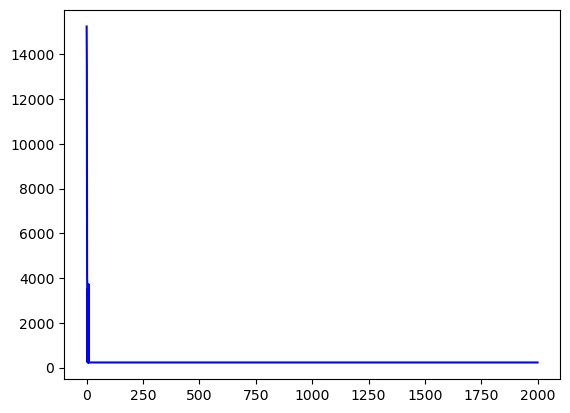

In [264]:
# Plot your loss function.
plt.plot(np.arange(len(losses)), losses, label='Loss Plot', color='blue')
print(losses)

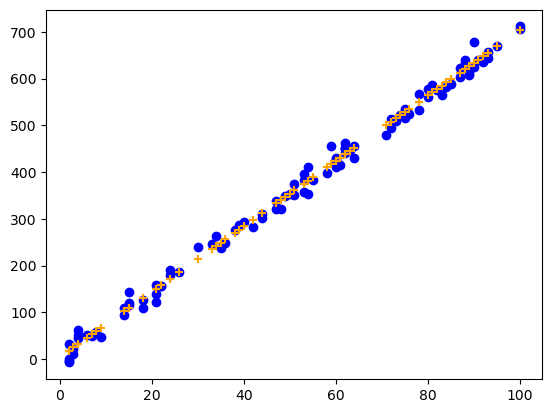

In [265]:
# Plot the model overlaid on the (x, y_measured) data points
plt.scatter(x, y_measured, label='Line Plot', color='blue', marker='o')
plt.scatter(x, predict(weights, x), color='orange', marker='+')

How close to the actual model parameters are we? You should pass the assertion below.

In [266]:
print(f"Actual model parameters: m={m}, b={b}")
print(f"Trained model parameters: m={weights[0]}, b={weights[1]}")

assert np.isclose(weights[0], m, rtol=0.1)

Actual model parameters: m=7, b=4
Trained model parameters: m=7, b=4


Much better!

> **Question 2c) What happens if you increase the learning rate?**

You may notice things go awry if the learning rate is too high... describe what is happening below.

*If the learning rate is too high, the algorithm may miss the minima and would not be able to converge*

### 3. Reporting Results

When training a model for classification for regression, we typically do not use the entire dataset for training. It is customary to split the dataset into a training set and test set.

> **Question 3a) Explain why we do not report model results on the training data? What is data leakage?**

*The model results on the training data is usually not a good representation of how the model would perform in the real world. This is because the model will overfit on your training data because it is used in each iteration of the epoch. This is why we use a validation/test (used interchangably at times) to test whether our model is overfitting. Data leakage occurs when data in the validation/text set is somehow "leaked" and the model trains on that data, causing the scoring metric to be inflated and resulting in an overestimation of the model's performance. A real world example would be how OpenAI's o3 model was secretly training on supposedly unseen math competition questions to boost leaderboard scoring performance*

In the code cell below, split the data set (x, y_measured) into training and test sets. Train the model on the training set and report your loss on the test set.

In [267]:
# Split dataset and report results on test set
# Your code here...
#from sklearn.model_selection import train_test_split

####### I would typically use sklearn's train_test_split, but I see that we've imported random_split and TensorDataset so I will be using that too
# # Splitting
# X_train, X_test, y_train, y_test = train_test_split(x, y_measured, random_state = random_seed, test_size = 0.2)


# # Grabbing weights from training and the respective loss (if needed)
# train_weight, train_loss = train(X_train, y_train, weights, gradient_func, 0.00027, 300)

train_size = int(0.8 * len(x))
test_size = len(y_measured) - train_size

dataset = TensorDataset(torch.tensor(x), torch.tensor(y_measured))

train_data, test_data = random_split(dataset, [train_size, test_size])

X_train = np.array([value for value, label in train_data])
y_train = np.array([label for value, label in train_data])
    
X_test = [value for value, label in test_data]
y_test = [label for value, label in test_data]


train_weight, train_loss = train(X_train, y_train, weights, gradient_func, 0.00027, 300)

# Predicting using the training weights on the X test set
q3_predict = predict(train_weight, X_test)

# Comparing the predicted y vs. the ground truth to get the loss 
test_loss = loss(q3_predict, y_test)

# printing test loss


> **Question 4a) What is the above equation when reformulated in linear algebra notation? Also, repeat Questions (1a) (1b) and (2b) for this problem statement.**

*4a) Is drawn down below! 1a) We want to learn the coefficients weights to model non-linear relationships between variables  1b) This is equivalent to a full connected dense layer 2b) If we are using * 
![alt text](images/poly_regression.jpeg)

First, let's re-establish our data set with a higher degree polynomial.

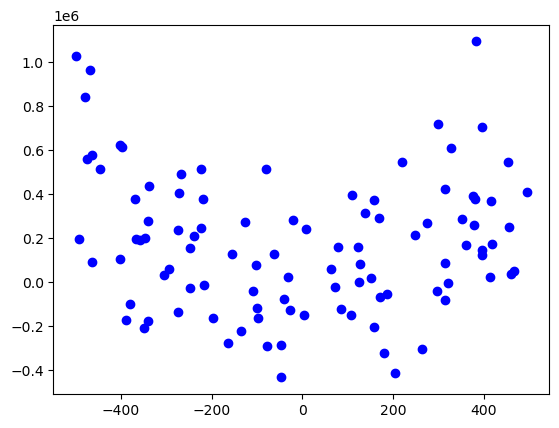

In [268]:
# Let's pick the polynomial degree
degree = 2 # Choose a number that suites you (Warning: code may become unstable with too high of a polynomial though)
num_weights = degree + 1 # Include w_0 (i.e the bias term)

# Creating a random model
true_weights = initialize_model(num_weights=num_weights) # We are using the intialize_model func to generate a random polynomial

# Generate a set of 100 (X,Y) coordinates that share the polynomial relationship
num_data_points = 100
upper_limit = 500
lower_limit = -500
x = np.random.randint(lower_limit, upper_limit, size=num_data_points)
y = np.sum(np.array([true_weights[i] * x**(degree - i) for i in range(len(true_weights))]), axis=0)

# Add noise to our y-vector
mu, sigma = 0, upper_limit**degree # We will make the noise commensurate with the polynomial degree
noise_vector = np.random.normal(mu, sigma, num_data_points)
y_measured = y + noise_vector

# Plot the (X,Y) points as a line plot using matplotlib
plt.scatter(x, y_measured, color='blue', marker='o')

Now, lets create our features (i.e. the polynomial terms)

In [269]:
# Step 0: Transform input vector x to include polynomial terms (1, x, x^2, x^3, .. x^(n-1), x^n)
def polynomial_features(x, degree):
    # Your code here
    matrix = []
    for num in x:
        arr = [num ** i for i in range(degree + 1)]  # Generate terms (1, x, x^2, ..., x^degree)
        matrix.append(arr)
    tensor = torch.tensor(matrix, dtype=torch.float)
    return tensor


X_poly = polynomial_features(x, degree)


Now, we accomplish Steps 1-4 from above.

In [270]:
# Step 1: Define training parameters
torch.manual_seed(random_seed)
learning_rate = 1e-16 # Start with low learning rate
num_epochs = 200 # Choose number that suits you # Epochs is the number of times we cycle through the entire dataset when training. Similar to 'num_steps' above.

In [271]:
# Step 2: Create your model using nn.Linear, starting with our random model weights
# Do not include a bias term, because it's included in polynomialization portion.
model = nn.Linear(in_features = X_poly.size()[1], out_features = 1, bias = False) # Your code here

> **Question 4b) What is your activation function for this neural network?**

*Linear activation function where the activation is proportional to my inputs*

In [272]:
# Step 2a: Add randomly initialized weights to our model
# (typically this is not necessary, but aligns this problem more closely with Section 3)
weights = initialize_model(num_weights=num_weights)
print(f"Random weights: {weights}")
model.weight.data = torch.from_numpy(weights).to(torch.float)

Random weights: [3 9 7]


In [273]:
# Step 3: Define loss function and optimizer from relevant pytorch classes.
# Note, we will want to use Stochastic Gradient Descent for the pytorch implementation

criterion = nn.MSELoss() # Your code here
optimizer = optim.SGD(params = model.parameters())

In [274]:
# Step 4: Create the training loop
def train(dataset, model, optimizer, num_epochs, batch_size=None):
  # Your code here
  # dataloader = DataLoader(dataset, batch_size)
  # Initialize empty list for loss
  losses = []
  model.train()
  for _ in range(num_epochs):
    for _, data in enumerate(dataset):
      inputs, labels = data
      
      # Zero gradients 
      optimizer.zero_grad()
      
      # Get prediction 
      prediction = model(inputs)
      
      # Get loss 
      loss = criterion(prediction, labels)
      losses.append(loss.item())
      
      # Backprop it up 
      loss.backward()
      
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      
      # Take a step
      optimizer.step()        
  return losses


Now call your train function. We need to convert our dataset from numpy to torch datatypes.

In [275]:
# Step 5: Create a train-test split
def train_test_split(X, y, train_ratio=0.8):

  # Your code here
  dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
  
  train_dataset, test_dataset = random_split(dataset, [train_ratio, 1 - train_ratio])
  
  train_dataloader = DataLoader(train_dataset)
  test_dataloader = DataLoader(test_dataset)

  return train_dataloader, test_dataloader

In [276]:
# Step 6: Call training loop
train_dataset, test_dataset = train_test_split(X_poly, y_measured)
losses = train(train_dataset, model, optimizer, num_epochs)

/var/folders/m7/gj3w__8s6yz14htr_wj0h2800000gn/T/ipykernel_94464/1466748224.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))


Let's visualize the results

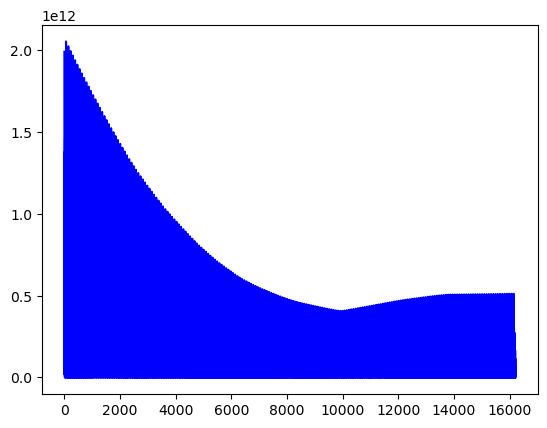

In [277]:
plt.plot(np.arange(len(losses)), losses , label='Loss Plot', color='blue')

In [278]:
test_dataset

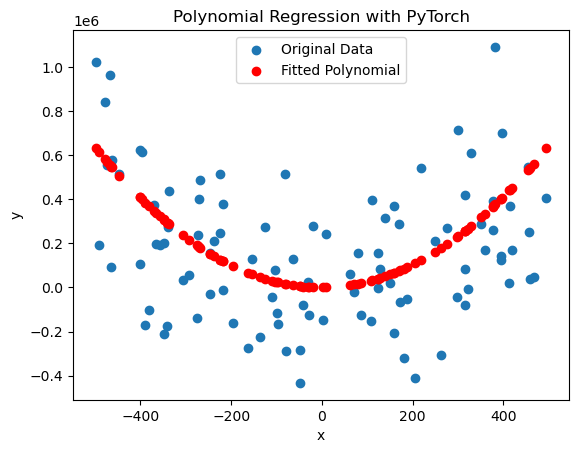

In [279]:
# Plot data and predictions
predictions = model(X_poly) # your code here
with torch.no_grad():
    plt.scatter(x, y_measured, label="Original Data")
    plt.scatter(x, predictions, color="red", label="Fitted Polynomial")
    plt.legend()
    plt.title("Polynomial Regression with PyTorch")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

Report your results on the test test. Write an evaluation function that evaluates your model performance.

In [280]:
def evaluate(test_dataset, model, criterion):
    # Set the model to evaluation mode
    model.eval()
    # Your code here
    test_loss = []
    for inputs, labels in test_dataset:
        prediction = model(inputs)
        
        loss = criterion(prediction, labels)
        test_loss.append(loss.item())
        
    print(f"Test MSE Loss: {loss.item():.4f}")
    return np.array(test_loss)

In [281]:
# Step 7: Evaluate model
evaluate(test_dataset, model, criterion)

Test MSE Loss: 20361711616.0000


array([2.62990922e+11, 1.09715118e+10, 1.66099226e+09, 7.21757962e+10,
       4.10768056e+10, 1.21438387e+09, 1.07531977e+11, 1.77348690e+11,
       8.41374515e+10, 5.22229350e+09, 1.92240976e+11, 1.10023642e+09,
       1.39150664e+10, 7.78667786e+10, 7.42814269e+10, 9.20250122e+10,
       6.66418094e+10, 3.50071235e+10, 2.03617116e+10])

Sometimes loss can be hard to interpret. How close are your model parameters to the true paramters?

In [282]:
print(f"Actual model parameters: {true_weights}")
print(f"Trained model parameters: {model.weight.data.numpy()}")

assert np.isclose(model.weight.data.numpy()[0], true_weights[0], rtol=1)

Actual model parameters: [ 2  7 10]
Trained model parameters: [2.981451  8.957075  2.5583968]


> **Question 4c) Out of all the model weights, it is likely the case that your trained model's first weight is the closest to the true model parameter. Why might this be the case?**

*I think as I increase the degree of the polynomial, the number of features will increase, adding more dimensions to my feature space. With only a single linear layer, it can only capture a linear relationship, resulting in the loss of being able to capture relationships in higher dimensions.*

### 5. **Real world regression task**

Let us now apply our knowledge towards a real-world regression task.

Our goal in this final section will be to develop a regression model for the California Housing Dataset. A description of the dataset results from running the below cell.

In [283]:
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing()

print(california.DESCR)

X, y = california.data, california.target

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce


We will not assume our dependent variable has a polynomial relationship on our independent variable.

In fact, we will only make a singular, relaxed assumption about the relationship between our dependen target variable (median house value) and the 8 independnet attributes: *That the relationship can be modeled using a multi-layer perceptron (i.e. an articial neural network).*

> **Question 5a) Why is a multi-layered perception (MLP) a reasonable choice for our regression model? On the other hand, what will be the MLP's shortcomings for this particular task?**

*Our dataset contains a lot of features and quite a lot of data that an MLP could find hidden abstractions from. MLP could overfit, use features that may not contribute to house value and it could be difficult interpreting what contributes to the median house value*

We will follow the same steps as in section 4

In [298]:
# Step 1: Define training parameters
learning_rate = 1e-7
num_epochs = 200 # Choose a number # Epochs is the number of times we cycle through the entire dataset when training. Similar to 'num_steps' above.
batch_size = 128 # Choose a number # Batch size is the number of data points we aggregate together for a single loss calculation and gradient step

In [299]:
# Step 2: Create your neural network.
# The first layer's input size should be 8.
# There should be at least one hidden layer.
# All layers should have a bias term (which is the default).
# There should be a non-linear activation function for each layer (except the output)
# The output size should be 1.
# Hint: nn.Sequential may be helpful

input_dim = 8 
output_dim = 1
model = nn.Sequential(
    nn.Linear(input_dim, 32, True),
    nn.ReLU(),
    nn.Linear(32, 64, True),
    nn.ReLU(),
    nn.Linear(64, 32, True),
    nn.ReLU(),
    nn.Linear(32, 16, True),
    nn.ReLU(),
    nn.Linear(16, 1)
)

> **Question 5b) What is your rationale for your architecture?**

*My first layer takes the input dimension and outputs to a 32 dimensional space to transform the input into an abstrct represetation, The ReLU activation functions will introduce non-linearity into the model. I increase the dimensionality again to try and identify complex patterns in the data, and finally I reduce the dimensions into a scalar output.*

In [300]:
# Step 3: Define loss function and optimizer from relevant pytorch classes.
criterion = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = learning_rate)

In [301]:
# Step 4: Create training loop. Feel free to rewrite Step 4 from Section 4.
# However, if the train() function from Section 4 was robustly implemented, it should work for this problem also.

# Fun loops to look at :) 
from tqdm import tqdm

def train(dataset, model, optimizer, num_epochs, batch_size=None):
    
    losses = []
    model.train(True)
    for i in tqdm(range(num_epochs)):
        for j, data in enumerate(dataset): 
            inputs, labels = data
            optimizer.zero_grad()
            
            prediction = model(inputs)
            
            loss = criterion(prediction, labels)
            losses.append(loss.item())
            
            loss.backward()
            
            optimizer.step()
    
    return losses


In [302]:
# Step 5: train_test_split the data Feel free to rewrite Step 5 from Section 4.
# However, if the train_test_split() function from Section 4 was robustly implemented, it should work for this problem also.

## Rewriting for fun
def train_test_split(X, y, train_ratio=0.8):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    dataset = TensorDataset(torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float))
    train, test = random_split(dataset, [train_ratio, 1 - train_ratio])
    train_dataloader = DataLoader(train, batch_size= batch_size)
    test_dataloader = DataLoader(test, batch_size=batch_size)
    
    return train_dataloader, test_dataloader

train_dataset, test_dataset = train_test_split(X, y)


In [303]:
# Step 6: Call training loop. It might take a minute or so to train.
train_dataset, test_dataset = train_test_split(X, y)
losses = train(train_dataset, model, optimizer, num_epochs, batch_size=batch_size)

  0%|          | 0/200 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/dl-bioscience/lib/python3.13/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniforge/base/envs/dl-bioscience/lib/python3.13/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 200/200 [00:34<00:00,  5.78it/s]


Let's visualize our loss

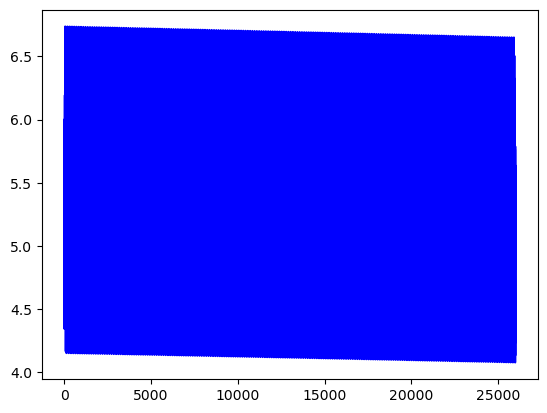

In [304]:
plt.plot(np.arange(len(losses)), losses, label='Loss Plot', color='blue')

Let's visualize how our predictions look compared to the targets. Obviously, we cannot use all 8 independent variables for our scatter plot, so we will have to pick one feature as our independent variable in the scatter plot.

In [291]:
# Step 7: Evaluate model
test_result = evaluate(test_dataset, model, criterion)

assert test_result < 0.6

Test MSE Loss: 5.0926


/opt/homebrew/Caskroom/miniforge/base/envs/dl-bioscience/lib/python3.13/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Let's contexualize our results, as raw regression loss can be difficult to interpret.

One way we can qualitatively check the performance of our neural network is by comparing the distribution of our predictions to the target values. Some may call this the 'eye-ball' test, or a 'sanity check' on our neural network. Ideally, these distributions should be quite similar. This indicates, to some degree, that our neural network is learning the conditional probability of y given the attributes X.

Let's compare our predictions to the the training and test targets below.


In [ ]:
# Plot your training predictions and target values as overlaid histograms.
# Ensure that the x-range of the hists are identical for adequate comparison.
X_train, y_train = 

# Forward pass to get predictions
predictions =

# Plot the histograms of y_train and predictions
# Your code here


In [ ]:
# Plot your test predictions and target values as overlaid histograms.
# Ensure that the x-range of the hists are identical for adequate comparison.
X_test, y_test =

# Forward pass to get predictions
predictions =

# Plot the histograms of y_test and test predictions
# Your code here


> **Question 5c) Describe the difference in distributions between your predictions and targets on the training and test sets. Does this seem reasonable? Are there differences in how your neural network predictions perform on the training vs test tests?**

*Double-click to add your answer...*

Let's get a quantitative measure of our test performance. We can calculate the $R^2$ measure of our predictions compared to test target values.

> **Question 5d) Explain what the $R^2$ metric measures? Report it for your model below**

*Double-click to add your answer...*

In [ ]:
# Report R^2 here
from sklearn.metrics import r2_score
r2 = r2_score(
    # Your code here
)
print(f"R^2: {r2}")

Congrats, you finished your first assignment! Feel free to try different architectures, hyperparameters, feature engineering approaches (i.e. standardizing your features), etc... to try to improve your neural network performance. Improving neural network performance is often an emprical process of trying out different configurations.